# Introduction

I've been grabbing MBTA bus location data every minute since August 4, for lines 77, 79, & 87, in anticipation of the Bus Rapit Transit pilot.  See Adam Auster's [writeup](https://wordonstreet.wordpress.com/2018/09/12/bus-priority-trials-oked/) for details and discussion of the pilot.

# If you just  want to skip to the plots of the data, click [here](#PlotsPlotsPlots).


Grabbing the data is pretty easy using [this API](https://github.com/jbarciauskas/mbtaapi3).  My entire script is
```
import mbtaapi
import datetime
api_instance = mbtaapi.VehicleApi()
D = ([datetime.datetime.now().isoformat()] +
     api_instance.api_web_vehicle_controller_index(api_key=SECRET_KEY, filter_route="77").data +
     api_instance.api_web_vehicle_controller_index(api_key=SECRET_KEY, filter_route="79").data +
     api_instance.api_web_vehicle_controller_index(api_key=SECRET_KEY, filter_route="87").data)
print(D)
```

I run this once every minute in a CRON job, which compresses the data and appends it to a file, with one file generated per day.


# Parsing the data into a Pandas DataFrame

## Parsing the snapshots
[Note: I should have saved off data via JSON to simplify the parsing.]

In [1]:
import ast
import gzip
import glob

# data was saved off as Python literals, so load it back in via the ast module.
def parse_snapshots(f):
    tmp = []
    results = []
    for l in gzip.open(f, "rt"):
        if l.startswith('[') and tmp:
            results.append(ast.literal_eval(" ".join(tmp)))
            tmp = []
        tmp.append(l.strip())
    results.append(ast.literal_eval(" ".join(tmp)))
    # remove the few non-dated snapshots
    return [r for r in results if '2018' in r[0]]

# Parse all the days we have data for, and concatenate them into a list of per-minute snapshots
data = [entry for f in sorted(glob.glob('../mbta_snapshot*.json.gz')) for entry in parse_snapshots(f)]
print("{} Snapshots taken".format(len(data)))

28397 Snapshots taken


## What's in the data?

Each snapshot has a date and a list of bus data.  The bus data has information about the the route, direction on the route, its latitude and longitude, a vehicle ID, and other data we'll mostly ignore.

In [2]:
import pprint
print("Timestamp:", data[0][0])
print()
print("Data for one bus")
pprint.pprint(data[0][1])

Timestamp: 2018-09-04T16:07:01.224919

Data for one bus
{'attributes': {'bearing': 270,
                'current_status': 'STOPPED_AT',
                'current_stop_sequence': 1,
                'direction_id': 1,
                'label': '0619',
                'last_updated': None,
                'latitude': 42.424835205078125,
                'longitude': -71.1851806640625,
                'speed': None},
 'id': 'y0619',
 'links': {'self': '/vehicles/y0619'},
 'relationships': {'route': {'data': {'id': '77', 'type': 'route'},
                             'links': None},
                   'stop': {'data': {'id': '7922', 'type': 'stop'},
                            'links': None},
                   'trip': {'data': {'id': '38262212', 'type': 'trip'},
                            'links': None}},
 'type': 'vehicle'}


## Converting to a DataFrame
I extract the data about positions, routes, and route direction and stick it in a DataFrame for further processing.

In [3]:
import pandas as pd

vehicle_positions = []

for d in data:
    timestamp = pd.to_datetime(d[0])
    for v in d[1:]:
        attr = v['attributes']
        route = v['relationships']['route']['data']['id']
        dir = attr['direction_id']
        if attr['current_stop_sequence'] is None:
            continue
        vehicle_positions.append([v['id'], timestamp, attr['latitude'], attr['longitude'], route, dir])

vehicle_positions = pd.DataFrame(vehicle_positions, columns="vehicle time lat lon route dir".split())
vehicle_positions.head()

,vehicle,time,lat,lon,route,dir
0,y0619,2018-09-04 16:07:01.224919,42.424835,-71.185181,77,1
1,y0623,2018-09-04 16:07:01.224919,42.373264,-71.120636,77,0
2,y0649,2018-09-04 16:07:01.224919,42.417885,-71.164780,77,0
3,y0652,2018-09-04 16:07:01.224919,42.372925,-71.122398,77,0
4,y0703,2018-09-04 16:07:01.224919,42.405315,-71.141823,77,1


## Adding locations along route 77 and converting to approximate distance from Harvard Square

The location data is in latitude and longitude.  I convert this to miles north and east of Harvard Square (I could have used the Arlington Heights Busway, but to make things simpler below, it's easiest to use one end or the other.  We don't want latitude/longitude directly, because of distortions due to latitude.)

I also add a few waypoints along the route here, which will be useful for plotting below.  I convert bus locations and waypoint locations into the same "N/E of Harvard" coordinate system.

In [4]:
l = dict(heights_busway = (42.4250376, -71.1860425),
        arlington_center = (42.415539,-71.1535001),
        lake_street = (42.4057083,-71.142363),
        crossing_parkway = (42.400908,-71.1360857),
        carhouse = (42.396706, -71.129125),
        porter_upland = (42.3881714, -71.1196717),
        harvard_square = (42.373611, -71.118889))

locs = sorted(l.values())
locals().update(l)

def latlon_to_miles(lat, lon):
    # turn into miles north & east of Harvard
    # 69 is the number of miles in one degree of latitude.
    return (lat - harvard_square[0]) * 69, (lon - harvard_square[1]) * 69 * cos(harvard_square[0] * pi / 180)

miles_positions = latlon_to_miles(vehicle_positions.lat, vehicle_positions.lon)
vehicle_positions['miles_north'] = miles_positions[0]
vehicle_positions['miles_east'] = miles_positions[1]

vehicle_positions = vehicle_positions.set_index('time')
vehicle_positions.head()

,vehicle,lat,lon,route,dir,miles_north,miles_east
time,,,,,,,
2018-09-04 16:07:01.224919,y0619,42.424835,-71.185181,77,1,3.534470,-3.379207
2018-09-04 16:07:01.224919,y0623,42.373264,-71.120636,77,0,-0.023921,-0.089052
2018-09-04 16:07:01.224919,y0649,42.417885,-71.164780,77,0,3.054894,-2.339269
2018-09-04 16:07:01.224919,y0652,42.372925,-71.122398,77,0,-0.047347,-0.178890
2018-09-04 16:07:01.224919,y0703,42.405315,-71.141823,77,1,2.187604,-1.169048


# Plotting all the snapshots

Now we have data in a form we can plot.  Let's see what it looks like!

First, it's useful to create a function that will plot bus locations along with the waypoints and other information.

In [5]:
# Plotting helper function

def plot_vehicles(subset, figtitle, **kwargs):
    scatter(subset.miles_east, subset.miles_north, marker='o', alpha=0.05, **kwargs)
    title('{}\n{} samples'.format(figtitle, len(subset)))
    for l in locs:
        ml = latlon_to_miles(*l)
        plot(ml[1], ml[0], '*', markersize=20, color='r')
    ylabel('miles north')
    xlabel('miles east')
    axis('equal')

## All the "route 77" samples

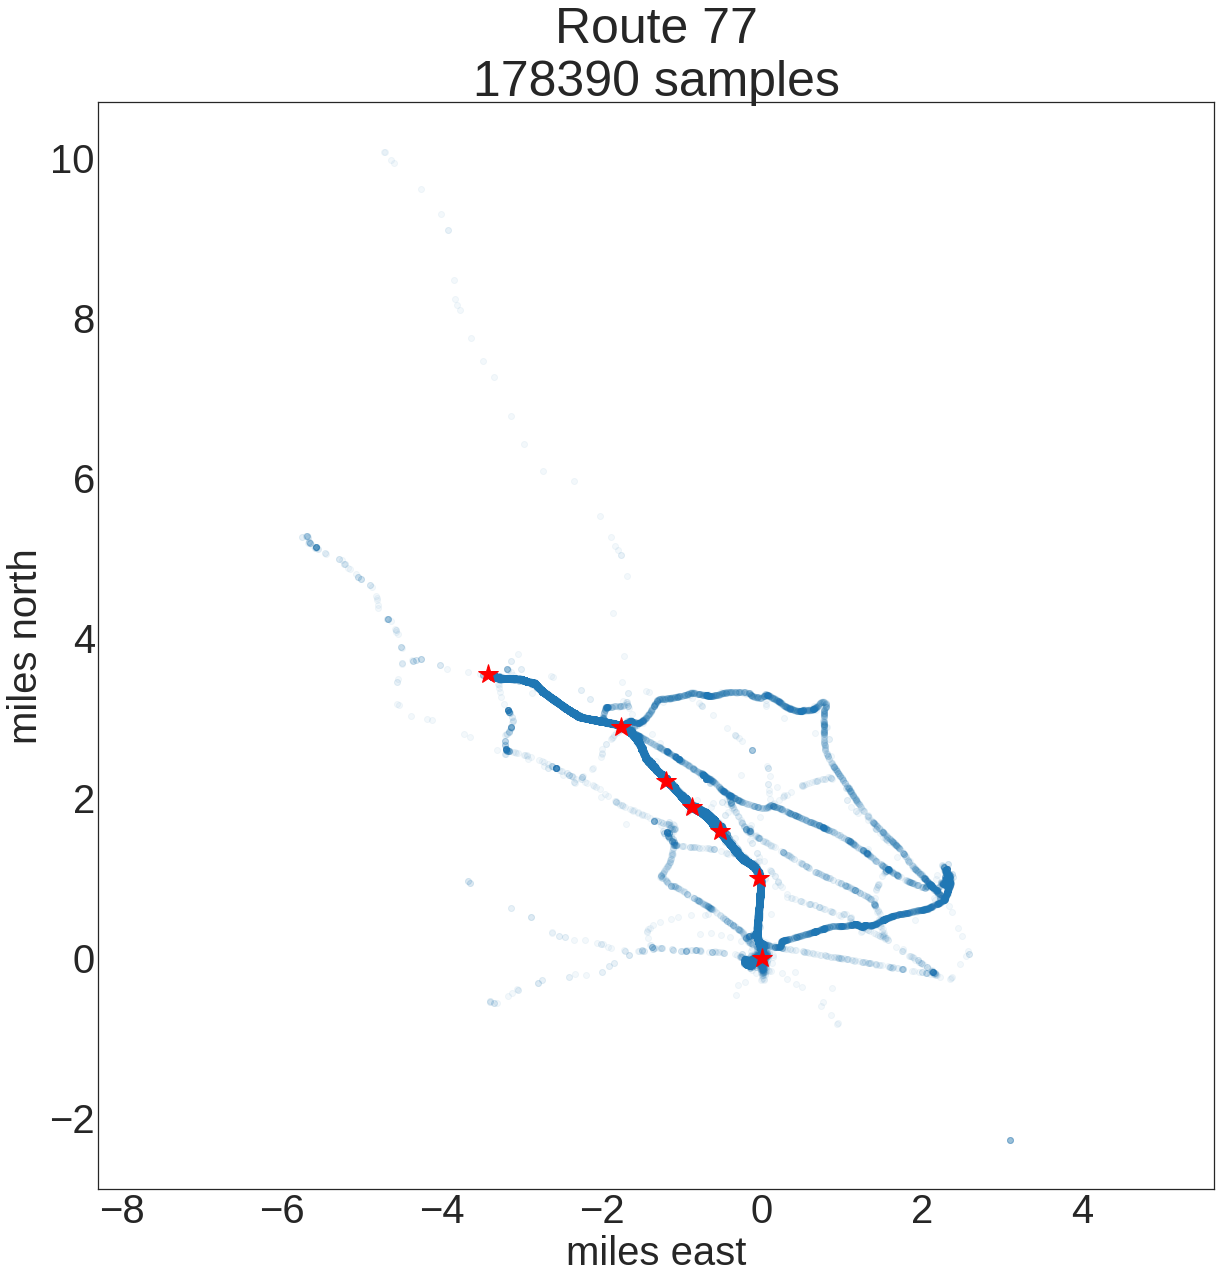

In [6]:
plot_vehicles(vehicle_positions.query("(route == '77')"), "Route 77")

## Data quality issues

Although we can see the 77 route from Arlington Heights to Harvard pretty clearly in the data, there are a large number of samples from buses that are obviously not on this route.  I'm not sure what's causing these.  It might be buses with their transponder set to the wrong route, or buses from the 77 route leaving or returning to the garages.  

In any case, we'll filter most of them out later.

First, some other plots.

### Inbound 77 between 7 a.m. and 10 a.m.

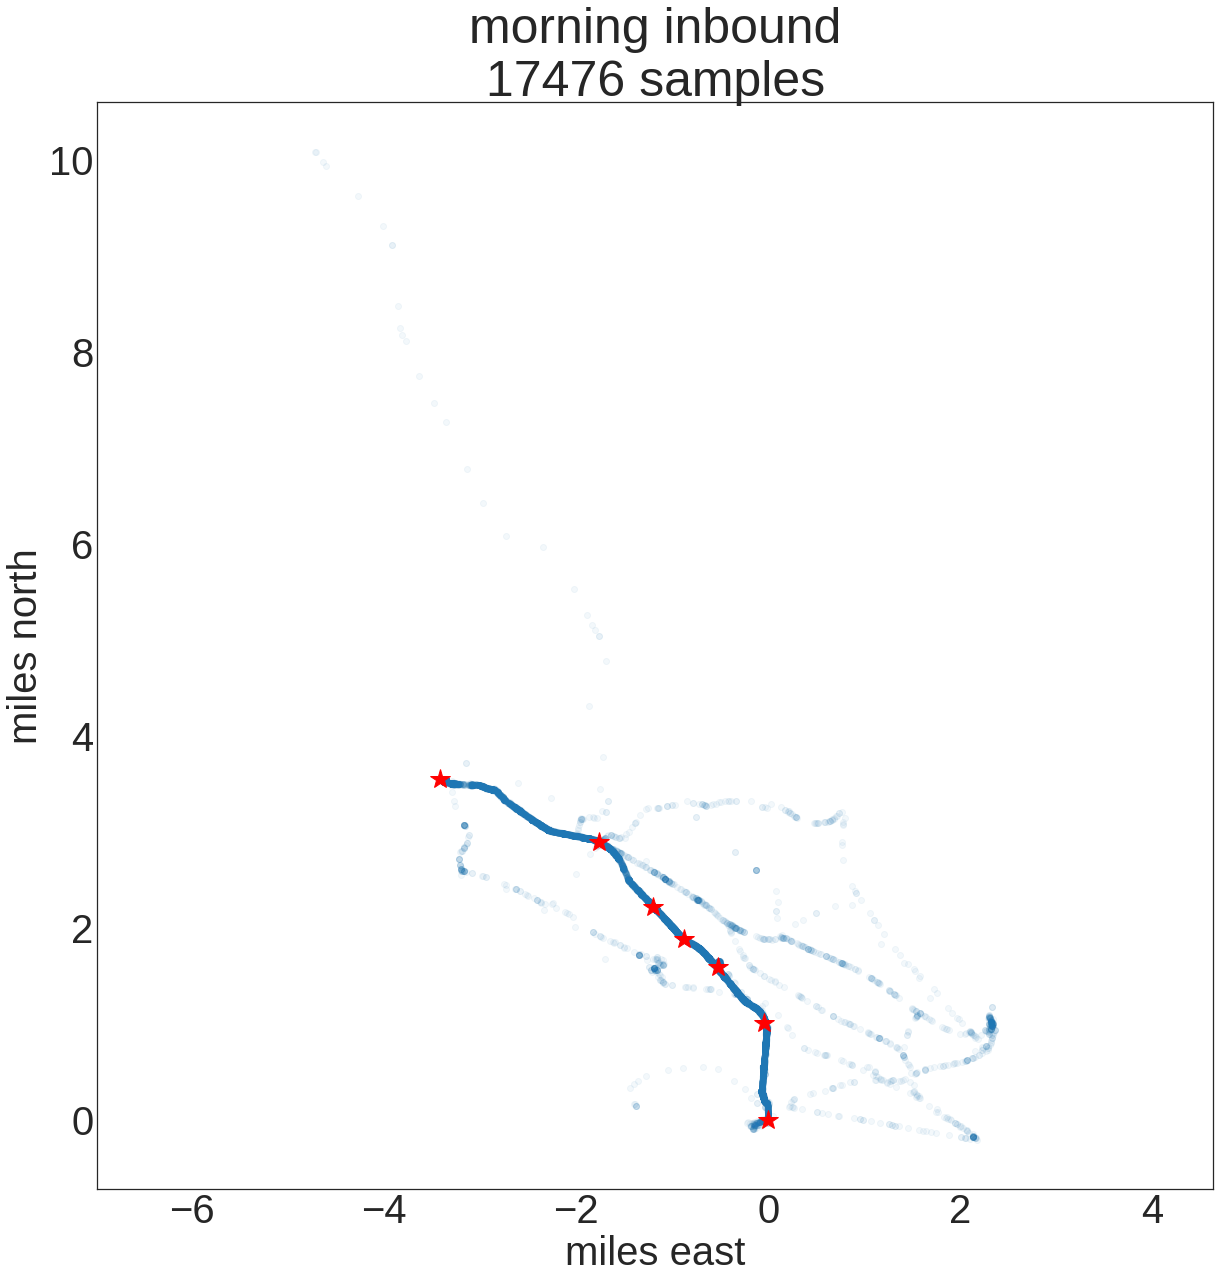

In [7]:
plot_vehicles(vehicle_positions.between_time("07:00", "10:00").query("(route == '77') and (dir == 1)"), "morning inbound")


### Outbound 77 between 7 a.m. and 10 a.m.

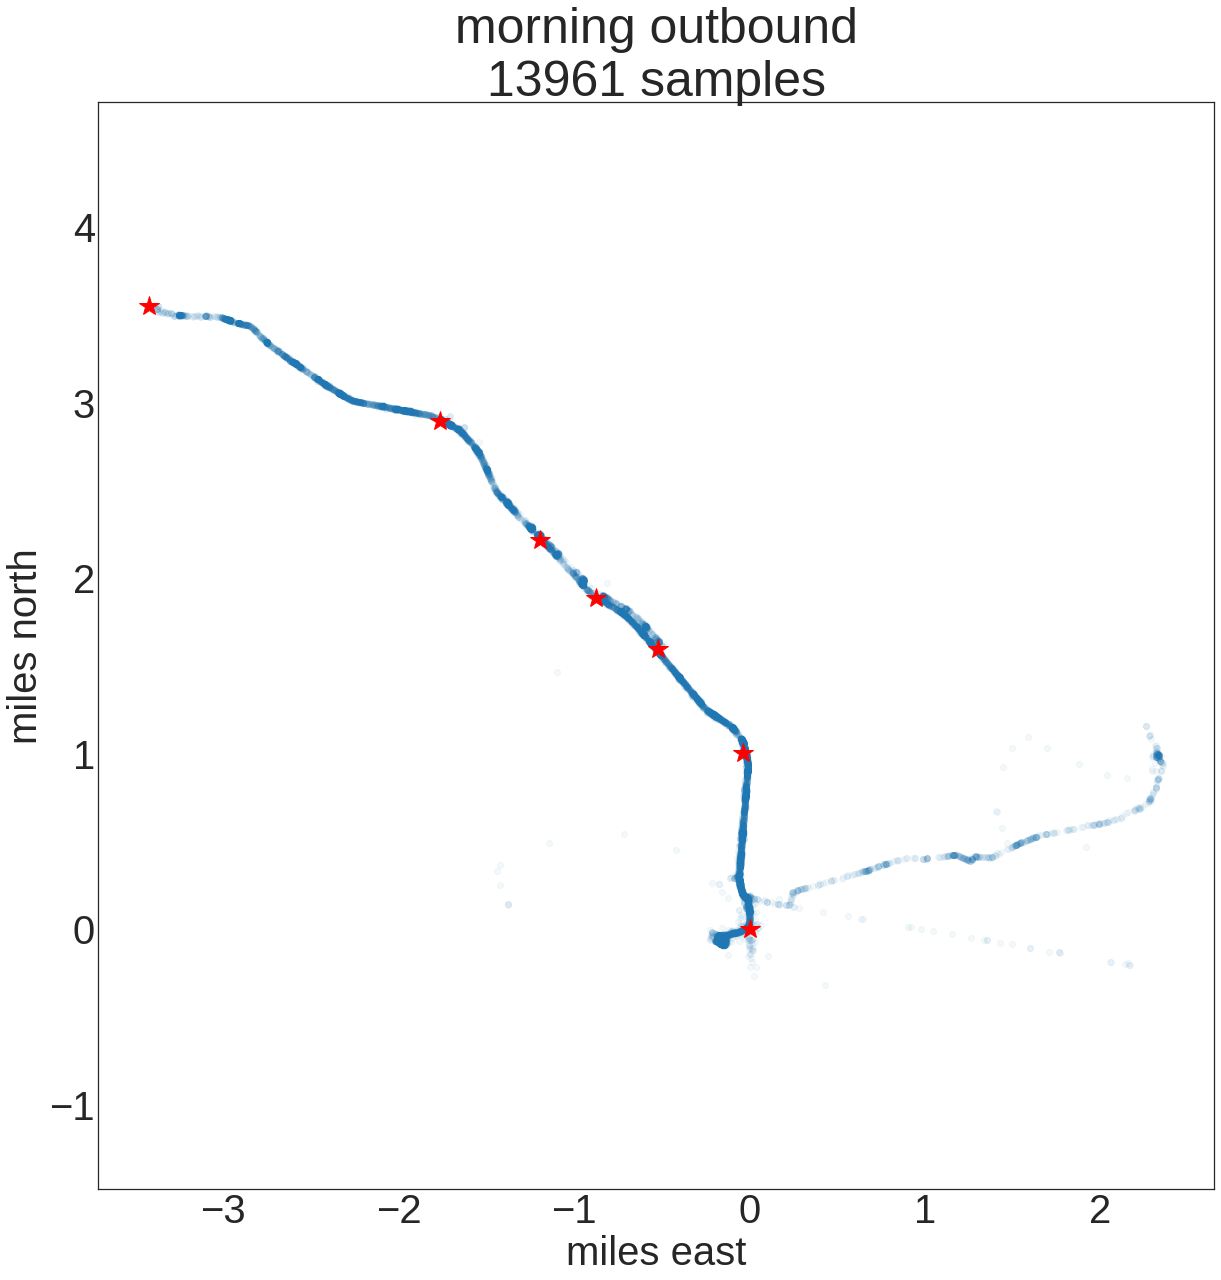

In [8]:
plot_vehicles(vehicle_positions.between_time("07:00", "10:00").query("(route == '77') and (dir == 0)"), "morning outbound")


### Inbound 77 between 10 a.m. and noon

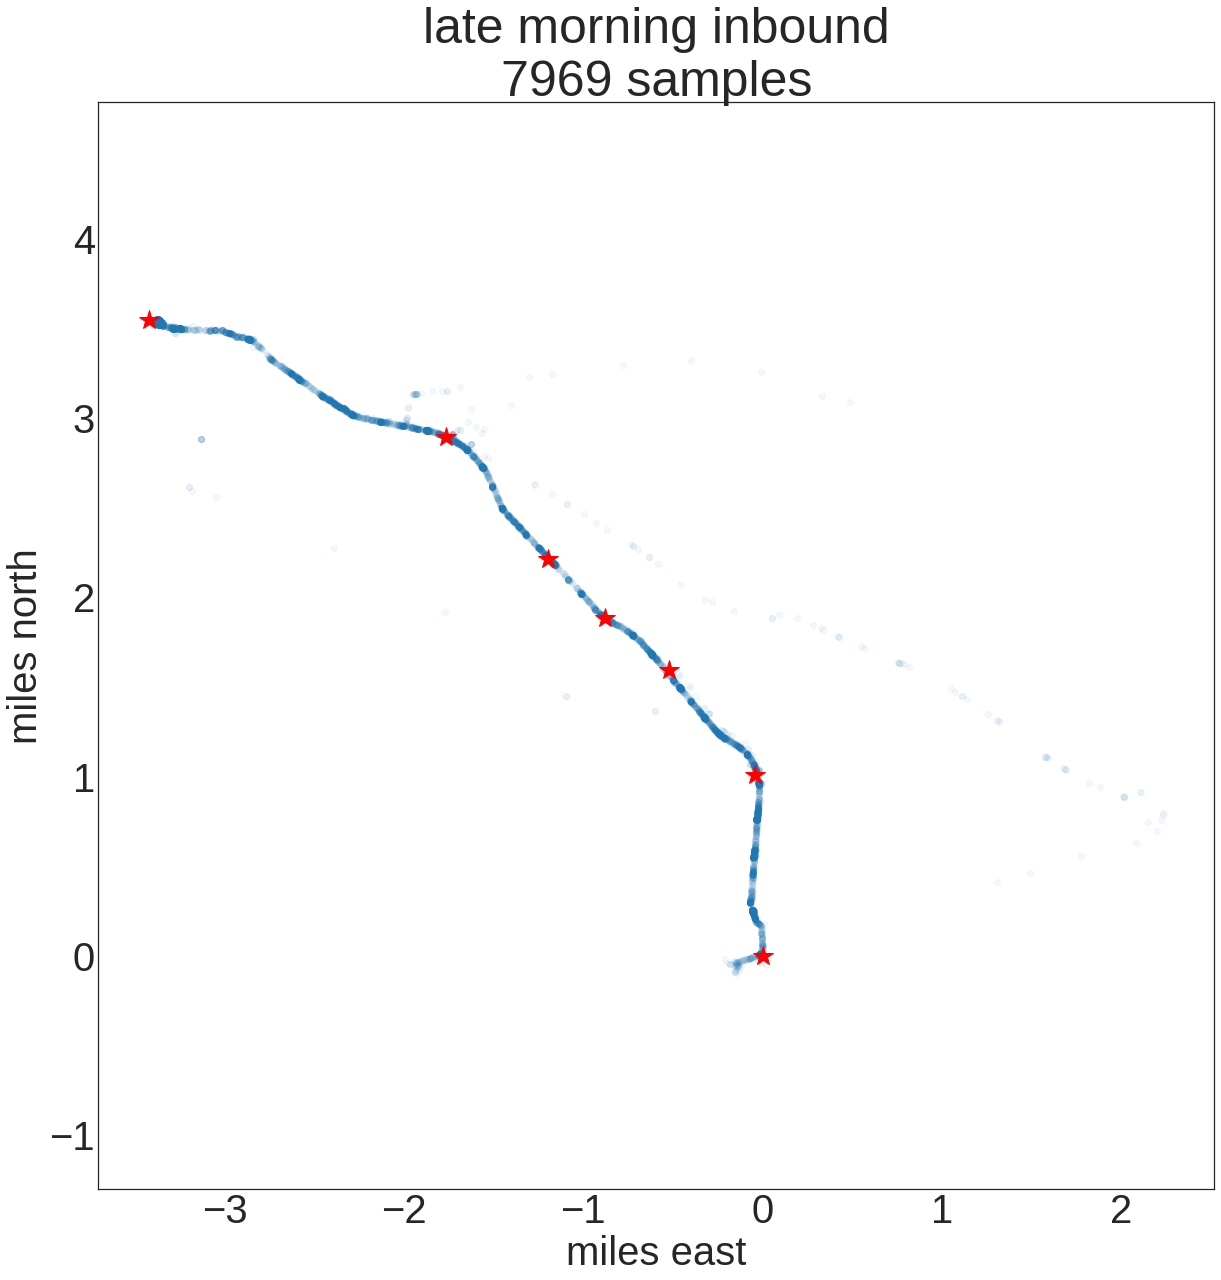

In [9]:
plot_vehicles(vehicle_positions.between_time("10:00", "12:00").query("(route == '77') and (dir == 1)"), "late morning inbound")


### Outbound 77 between 10 a.m. and noon

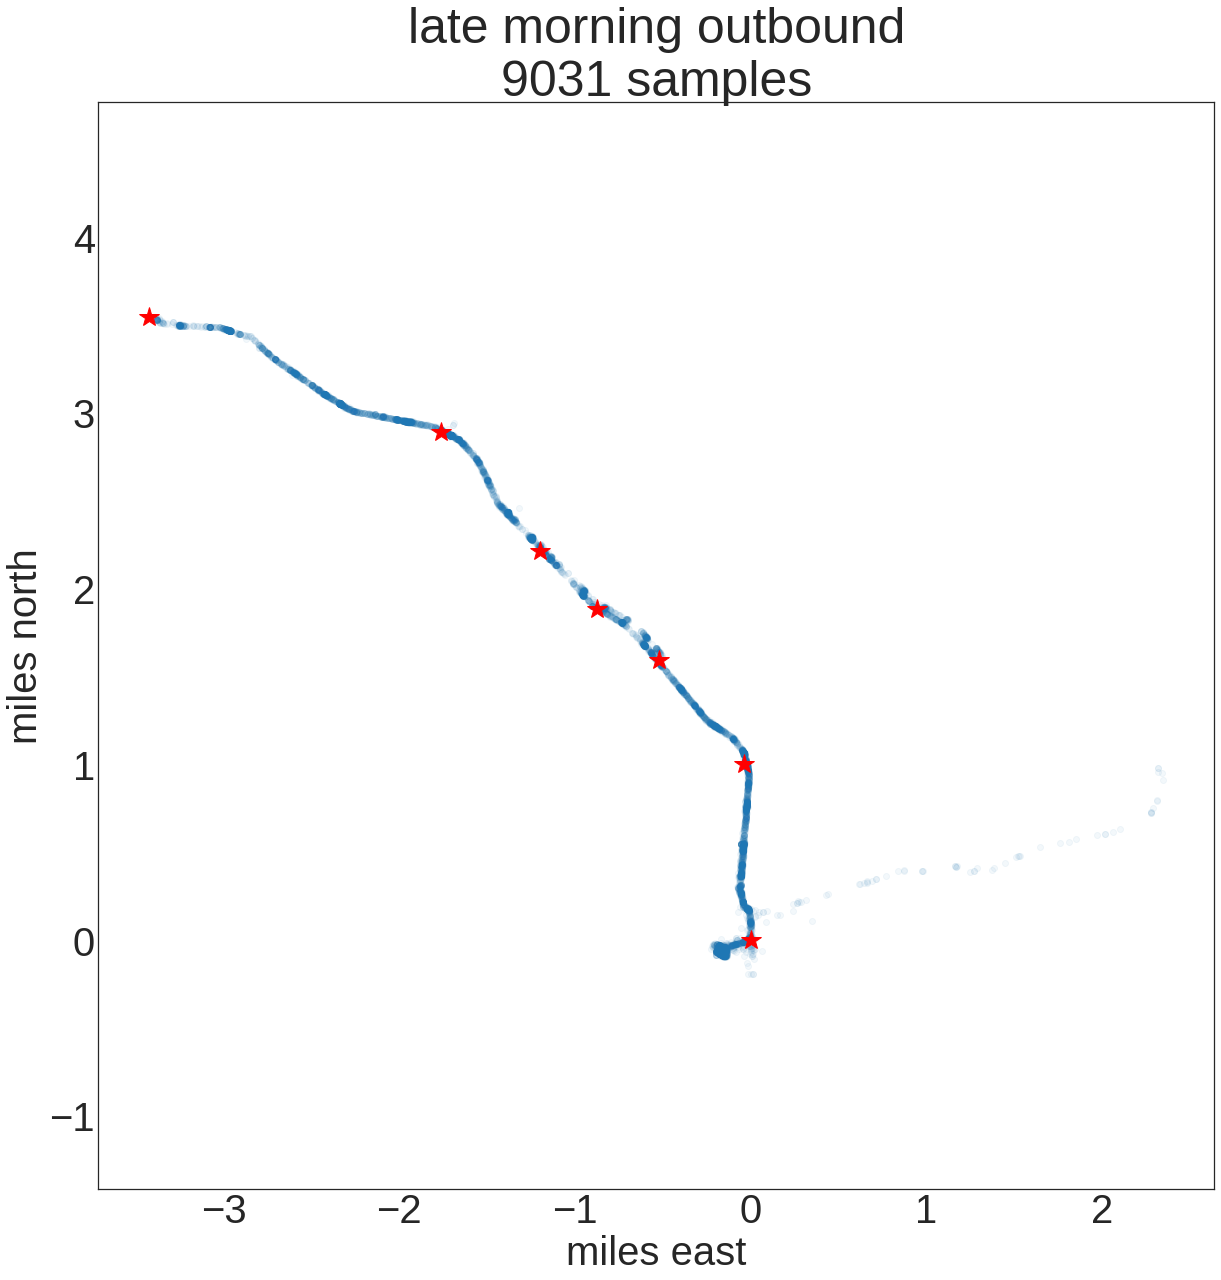

In [10]:
plot_vehicles(vehicle_positions.between_time("10:00", "12:00").query("(route == '77') and (dir == 0)"),  "late morning outbound")

## Filtering out bad data

To remove the buses that are off the actual 77 route, we'll find their distance from any section between the waypoints, and remove anything more than 1/8 of a mile off track.

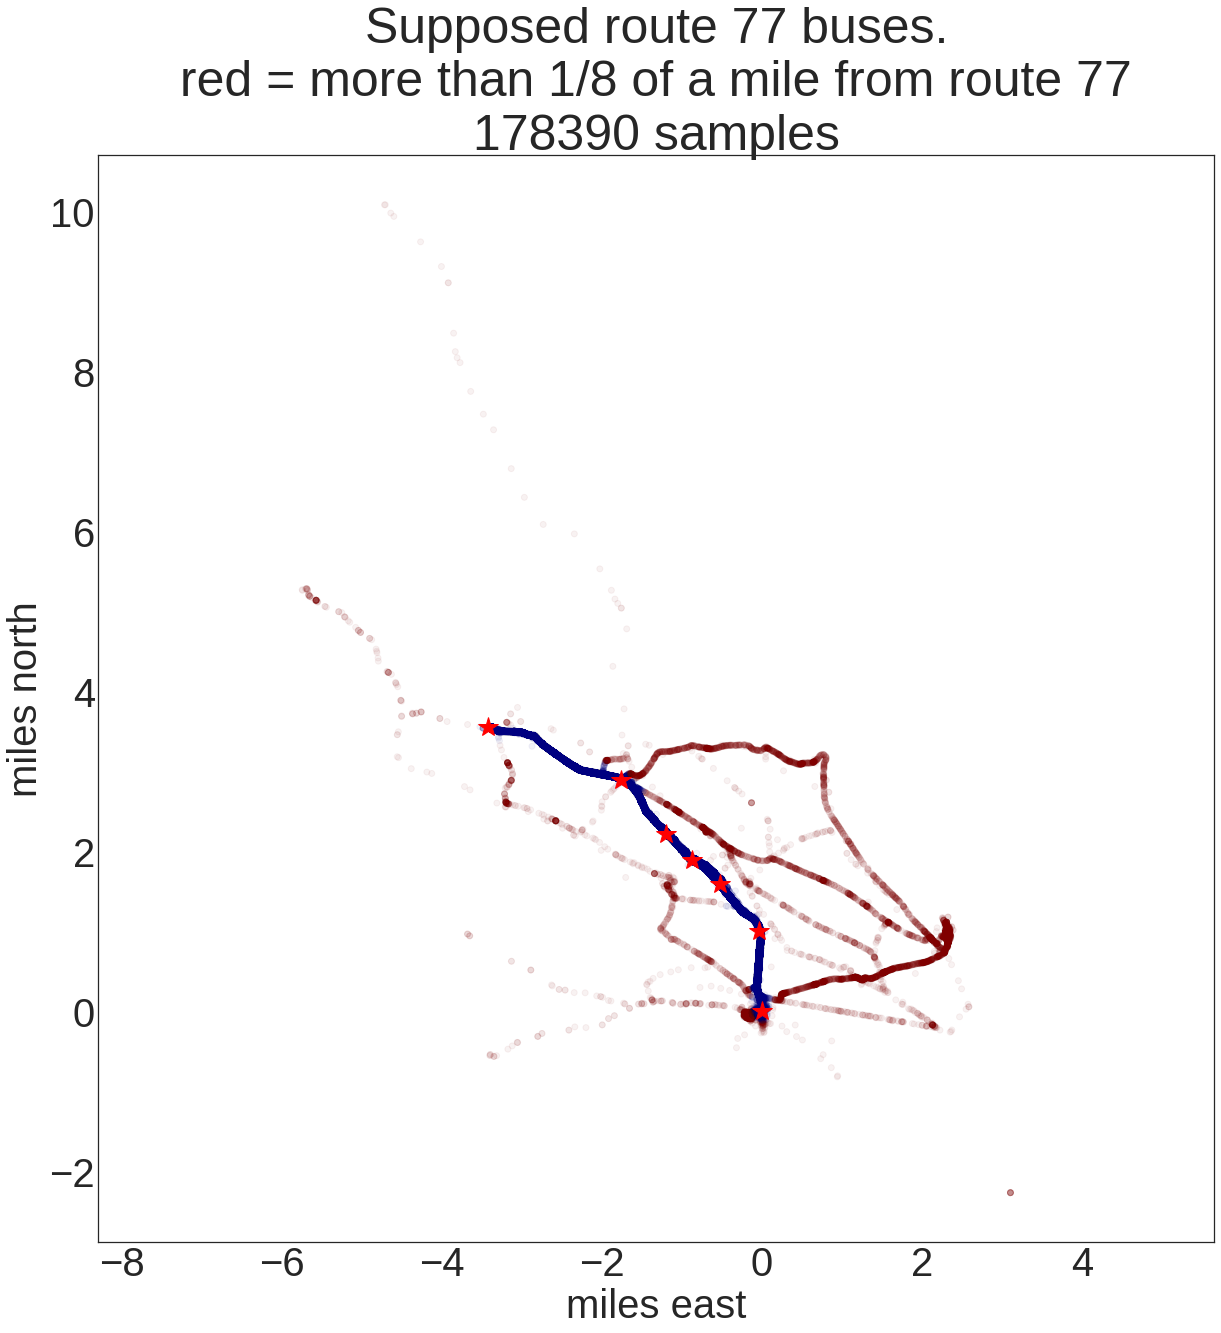

In [11]:
# adapted from https://stackoverflow.com/questions/27161533/find-the-shortest-distance-between-a-point-and-line-segments-not-line
from point_to_line import pnt2line

miles_locs = [array(latlon_to_miles(*l))[::-1] for l in locs]  # [[::-1] to put in east/north == X/Y order

min_D = np.inf * np.ones(len(vehicle_positions))
for idx in range(len(miles_locs) - 1):
    D, P = pnt2line(vehicle_positions['miles_east miles_north'.split()].values, miles_locs[idx], miles_locs[idx + 1])
    min_D = minimum(D, min_D)

vehicle_positions['distance_from_route_77'] = min_D

supposed_77s = vehicle_positions.query("(route == '77')")
plot_vehicles(supposed_77s, "Supposed route 77 buses.\nred = more than 1/8 of a mile from route 77",
              c=(supposed_77s['distance_from_route_77'] > 0.125), cmap='jet')

<a name="PlotsPlotsPlots"></a>
# Marey diagrams of Route 77 Inbound on weekday mornings

## (scroll down for the plot)

This type of plot is [Étienne-Jules Marey](https://en.wikipedia.org/wiki/%C3%89tienne-Jules_Marey).  There's a nice discussion of them [on this page](https://ozagordi.github.io/2016/11/19/a-very-simple-plot/).

On this plot, buses move left-to-right, from Arlington Heights to Harvard.  Time increases downward, from 6:30 to 11:00 a.m.  I approximate the distance from Harvard Square as the straight line between the Arlington Heights and Harvard Square (about a 10% error).  I only took weekdays.

The backup between Lake Street and Route 16 between 7:30 and 9:30 in the morning is easy to pick out (in the center of the plot).  Buses can also be seen leaving the carhouse in the morning toward Harvard.

It's also possible to see the "three-light effect" at Lake street, where a short stall in progress tends to occur, as the bus ends up waiting through multiple lights (zero-to-one to get to the stop, one to pick up passengers, one to get going again).  The sensors added to the lights at Lake to extend the green when a bus is approaching, along with moving the stop, should help alleviate this.

There are still a few artifacts in the data, some of which I try to remove by filtering out buses moving backward or not reporting in for more than 10 minutes.

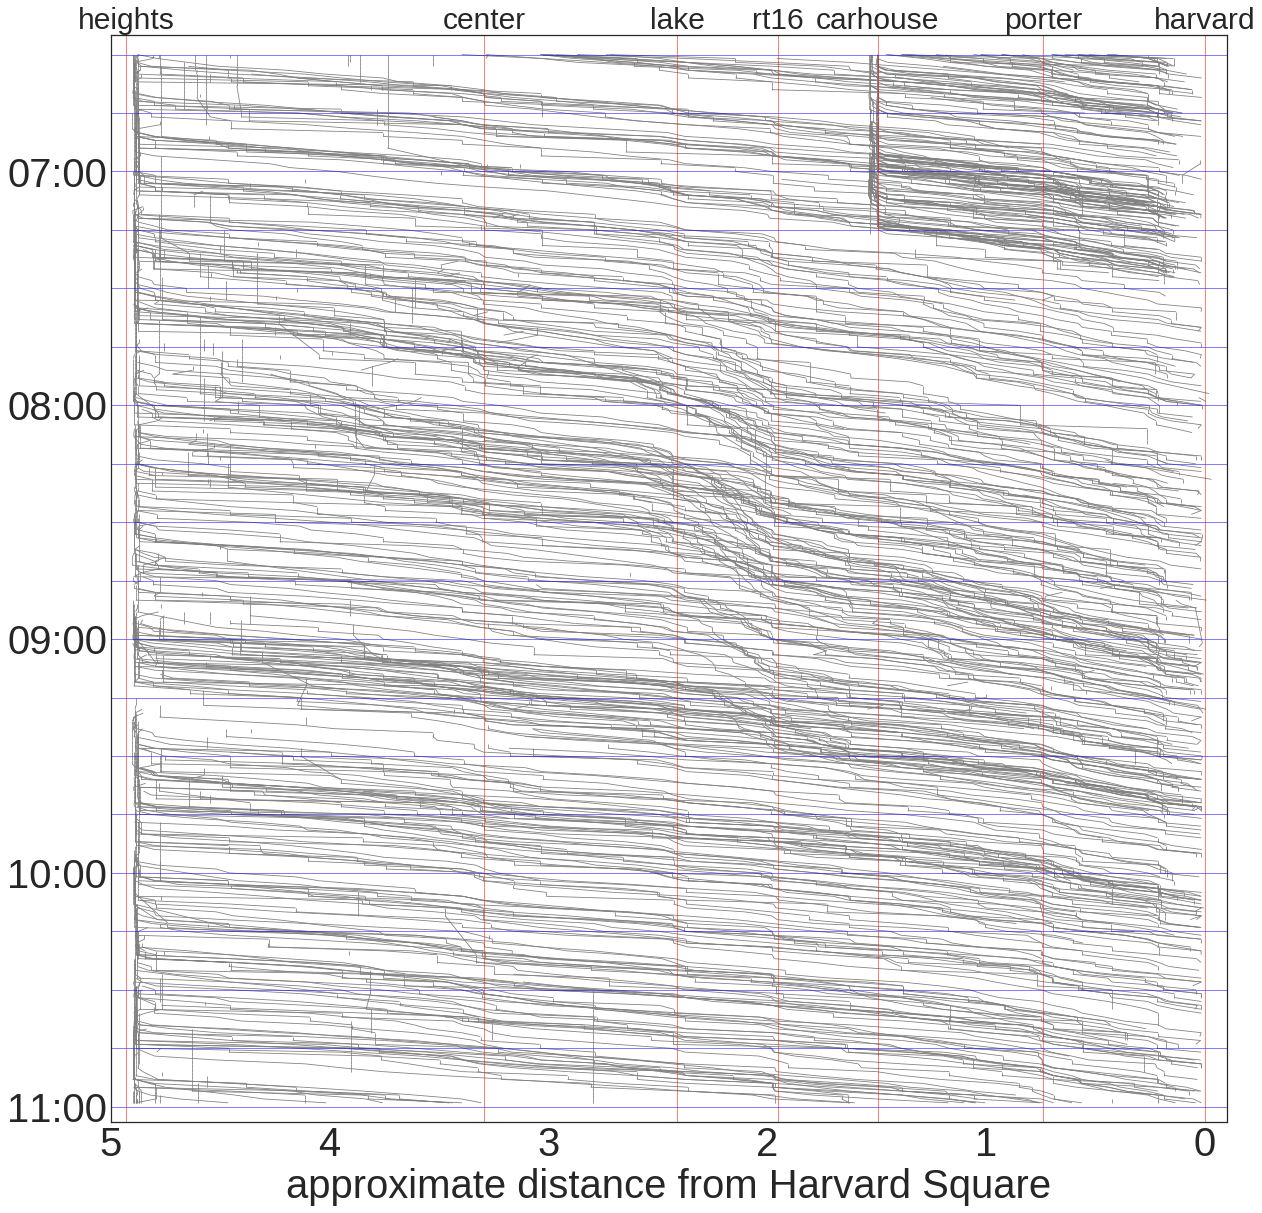

In [12]:
from matplotlib.collections import LineCollection

valid_77 = vehicle_positions.query('(route == "77") and (dir == 1) and (distance_from_route_77 < 0.125)').copy()
valid_77['T'] = valid_77.index.time
valid_77['P'] = (valid_77.miles_north - valid_77.miles_east) / sqrt(2)

def num_minutes(t):
    return 60 * t.hour + t.minute

line_segs = []
# Loop over individual vehicles and plot them
for veh, gr in valid_77.between_time("06:30", "11:00").groupby('vehicle'):
    for idx in range(len(gr) - 1):
        weekday = gr.index.weekday[idx]
        if weekday >= 5:  # Monday == 0, Saturday = 5, Sunday = 6
            continue
        p1 = gr.P.iloc[idx]
        p2 = gr.P.iloc[idx + 1]
        t1 = gr['T'].iloc[idx]
        t2 = gr['T'].iloc[idx + 1]

        # drop any locations for the same bus spaced by more than 10 minutes
        if abs(num_minutes(t2) - num_minutes(t1)) > 10:
            continue

        # drop any locations where the bus went backwards
        if p1 - p2 < -0.1:  # values should be decreasing
            continue

        line_segs.append([[p1, num_minutes(t1)], [p2, num_minutes(t2)]])

# Plot the lines
line_segs = array(line_segs)
lc = LineCollection(line_segs)
lc.set_linewidth(.8)
lc.set_color('gray')

# Decorate the plot
gca().add_collection(lc)
xlabel('approximate distance from Harvard Square')
xlim(7, -0.1)
names = "heights center lake rt16 carhouse porter harvard".split()[::-1]

xlim(5, -0.1)
yticks(arange(0, 25 * 60, 60), ["{:02d}:00".format(i) for i in arange(25)])
tks = yticks()
for minor_tick in arange(0, 25 * 60, 15):
    axhline(minor_tick, lw=0.5, c='b')
tks[1]
ylim(line_segs[:, :, 1].max() + 5, line_segs[:, :, 1].min() - 5)
ymax, ymin = ylim()
for (a, b), n in zip(miles_locs, names):
    axvline((b - a) / sqrt(2), c='r', lw=0.5)
    text((b - a) / sqrt(2), ymin, n, va="bottom", ha="center", fontsize=30)

# How bad is the backup at Route 16?

From the plots above, it looks like if you catch the bus *after* Route 16 around 8:30, you'll get to Harvard Square in about 20-25 minutes (the blue lines are 15 minute increments).

If you catch the bus at Lake Street at 8:30, your trip will last about 40-45 minutes.  Note that the time to travel between Lake Street and Route 16 outisde of the morning rush hour (around 7:00 or after 10:00) is neglible.

There are a few buses that zoom through the Route 16 intersection without delay.  Although this plot is only for weekdays, it does still include a few school holidays (Rosh Hoshanah & Yom Kippur).  Taking those days out and looking at them separately is on my TODO list.

### Flipping time and space for those that prefer that sort of thing.

Same plot, but with buses moving bottom to top, from Arlington Heights to Harvard.

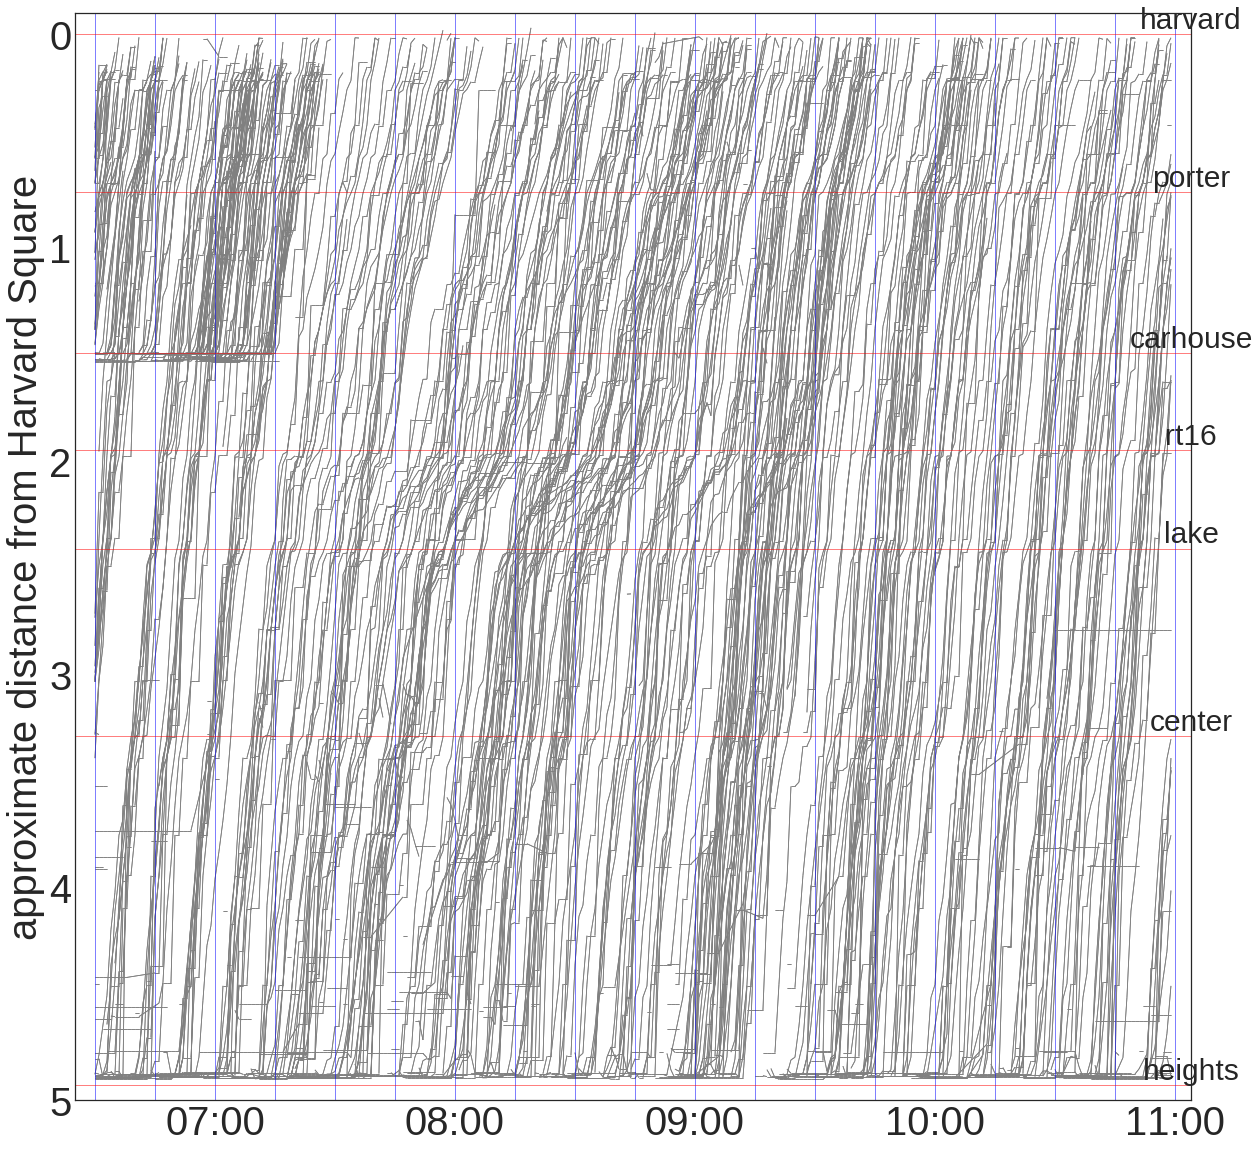

In [13]:
# same plot, but distance & time axes swapped

line_segs = []
for veh, gr in valid_77.between_time("06:30", "11:00").groupby('vehicle'):
    for idx in range(len(gr) - 1):
        weekday = gr.index.weekday[idx]
        if weekday >= 5:  # Monday == 0
            continue
        p1 = gr.P.iloc[idx]
        p2 = gr.P.iloc[idx + 1]
        t1 = gr['T'].iloc[idx]
        t2 = gr['T'].iloc[idx + 1]
        if abs(num_minutes(t2) - num_minutes(t1)) > 10:
            continue
        if p1 - p2 < -0.1:  # values should be decreasing
            continue
        line_segs.append([[num_minutes(t1), p1], [num_minutes(t2), p2]])

line_segs = array(line_segs)
lc = LineCollection(line_segs)
lc.set_linewidth(.8)
lc.set_color('gray')
gca().add_collection(lc)

gca().add_collection(lc)
ylabel('approximate distance from Harvard Square')
ylim(5, -0.1)
names = "heights center lake rt16 carhouse porter harvard".split()[::-1]

xticks(arange(0, 25 * 60, 60), ["{:02d}:00".format(i) for i in arange(25)])
tks = xticks()
for minor_tick in arange(0, 25 * 60, 15):
    axvline(minor_tick, lw=0.5, c='b')
tks[1]
xlim(line_segs[:, :, 0].min() - 5, line_segs[:, :, 0].max() + 5)
xmin, xmax = xlim()
for (a, b), n in zip(miles_locs, names):
    axhline((b - a) / sqrt(2), c='r', lw=0.5)
    text(xmax, (b - a) / sqrt(2), n, va="bottom", ha="center", fontsize=30)

# TODO
- Flow plots leaving the Heights every 15 minutes, and using the local average speed (in time & space) to generate average behaviors
- Variance plots, showing how much variability in travel time depends on time of day (and starting location)
- Other ideas from http://mbtaviz.github.io/
- Separate plots for school holidays
- Compute more accurate distance along route (currently using straight-line distance to Harvard Square).